# timeframe: 2011-02-21 to 2018-09-09

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import spacy
from textblob import TextBlob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import words
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, MWETokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation, NMF

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, MeanShift

from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance

from sklearn import preprocessing

from sklearn import metrics

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

import joblib
pd.options.display.colheader_justify = 'right'
pd.options.display.column_space = 1
pd.options.display.expand_frame_repr = True
pd.options.display.max_colwidth = 120

In [38]:
df = joblib.load('data/clean/clean_df.joblib')
df = df.loc[df.body != 'full quote', :] # drop the 'full quote' only comment
df = df[~df.body.str.contains("streamable mirror")] # Drop twitter bot comments

In [3]:
# don't use stemming with Word2Vec

In [4]:
# TODO: Properly do entire data set and a train_test_split later on
df_small = df.sample(30000, random_state=0)

df_small_train = df_small[:int(0.7 * df_small.shape[0])]
df_small_test = df_small[int(0.7 * df_small.shape[0]):]

# TF

### Next steps:
1. I want to find the X topics/clusters about these texts. Perhaps it's fitness, politics, training, performance, GOAT.
2. Figure out which topic each document best corresponds to, and place the document within that topic/cluster
3. Chart a stacked-bar or a multi-line chart for each year (or month, or something else) from 2011-2018, and show
   the PERCENTAGE (Or COUNT) of each topic for that period of time.
4. Look at the insights! What does that mean?
5. Perhaps do sentiment analysis. See if I can find a well-trained model. Or train my own based on upvote? score? (Probably not doing this)

**NOTE**: Simply do LDA first, and make this work. Get a chart. Get some insights.
**THEN:** Make it repeatable. Get it in a function somehow. Try other Dim Red and Unclassifying and Topic modeling techniques. See what works best.

In [39]:
def see_lda_topics(vectorizer, n_topics, fit_lda, n_examples):
    '''
    Prints top 10 names assigned to the topics, and the topics themselves
    '''
    vocab = vectorizer.get_feature_names()
    for topic in range(n_topics):
        print(f"TOPIC {topic}")
        for j in np.argsort(-fit_lda.components_,1)[topic,:n_examples]:
            print(vocab[j])
        print()

In [105]:
words_corpus = set(words.words())
analyzer = CountVectorizer().build_analyzer()
stem = SnowballStemmer('english')

stops = stopwords.words('english')
stops += ['lebron', 'james', 'game', 'us', 'need', 'let', 'well', 'year', 'dude', 'could', 'couldnt',
          'gon', 'gonna', 'na', 'ca', 'really', 'man', 'much',# 'last', 'next',
          'just', 'lol', 'like', 'im', 'he', 'hes', 'would', 'get', 'going', 'got', 'every', 'shit',
          'doesnt', 'th', 'fuck', 'think', 'even', 'dont', 'even', 'pretty', 'really', 'one',
          'didnt', 'cant', 'say', 'see', 'look', 'go', 'said', 'also', 'still', 'good'
         ]
stops = set(stops)
acceptable_words = words_corpus - stops

# create a custom vectorizer class that inherits from base class
# add a few more custom preprocessing and tokenization steps
class CustomVectorizer(CountVectorizer):  
    def build_analyzer(self):
        stop_words = stops
        
        def analyzer(doc):
            
            # preprocess: do any further cleaning here if needed
            # example: remove everything but letters
#             cleaned_doc = re.sub(r"[^A-Za-z]", " ", doc)
            cleaned_doc = doc
    
            # instantiate snowball stemmer
            stemmer = SnowballStemmer("english")
            # create tokens
            tokens = [stemmer.stem(d) for d in word_tokenize(cleaned_doc) if d in acceptable_words]
            tokens = [token for token in tokens if len(token) > 3]
            
            # multi-word expression tokenizer
            tokenizer = MWETokenizer()
            tokenizer.add_mwe(('k', 'love'))
            tokenizer.add_mwe(('kevin', 'love'))
            tokenizer.add_mwe(('dwayne', 'wade'))
            tokenizer.add_mwe(('d', 'wade'))
            tokenizer.add_mwe(('jr', 'smith'))
            tokenizer.add_mwe(('j', 'r', 'smith'))
            tokenizer.add_mwe(('j', 'r'))
            # tokenize the tokens
            tokens = tokenizer.tokenize(tokens)
            
            return(self._word_ngrams(tokens, stop_words))
        return analyzer

In [50]:
# def english_corpus(doc, stemmer=stem):
#     clean_words = [stemmer.stem(w) for w in analyzer(doc) if w in acceptable_words]   
#     return [stemmer.stem(w) for w in analyzer(doc) if w in acceptable_words]

Current isues:
* can't use stemmer and n_grams at same time.
* still too many junk words, even with growing stop_list
* **don't have a lemmatizer in there. How can i do lemmatize, n_grams, stop words, and stemmer all in analyer?**

In [51]:
# BI GRAMS

In [52]:
# cVectorizer = CustomVectorizer(# strip_accents='ascii',
#                                max_df=0.70,
#                                min_df=4,
#                                stop_words = stops,
#                                ngram_range=(2,2)
#                               )

# dtm_tf_custom = cVectorizer.fit_transform(df_small_train.body)
# #dtm_tf_custom.shape

# for n_topic in range(4,10):
#     loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0)
#     loop_lda_tf.fit(dtm_tf_custom)
#     print(':::::')
#     print(f'Number of topics = {n_topic}')
#     print(':::::')
#     see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 10)

In [53]:
# MOSTLY UNI GRAMS. ALLOWS BI AND TRI GRAMS

In [67]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.7,
                               min_df=4,
                               stop_words = stops,
                               ngram_range=(1,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df.body)
#dtm_tf_custom.shape

for n_topic in range(7,10):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0, n_jobs=-1)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 15)

:::::
Number of topics = 7
:::::
TOPIC 0
one
season
better
player
best
leagu
point
ever
shoot
year
curri
make
per
defens
time

TOPIC 1
love
time
year
play
great
coach
defens
day
one
mani
last
actual
feel
post
back

TOPIC 2
win
team
could
top
basketbal
right
time
peopl
goat
take
player
make
last
probabl
one

TOPIC 3
team
play
pick
pass
best
take
player
anyon
way
better
bad
someon
els
big
everyon

TOPIC 4
wade
peopl
guy
come
heat
want
talk
new
know
confirm
give
nice
fan
team
hate

TOPIC 5
team
year
back
first
win
season
know
one
best
come
tripl
doubl
next
trade
make

TOPIC 6
watch
damn
dude
ball
high
play
jordan
call
know
actual
time
never
k
great
foul

:::::
Number of topics = 8
:::::
TOPIC 0
one
player
best
leagu
make
ever
shoot
season
point
seen
better
defens
curri
team
time

TOPIC 1
love
time
great
year
play
coach
defens
actual
day
one
post
way
lue
last
feel

TOPIC 2
win
basketbal
top
right
could
time
team
peopl
goat
take
player
make
beat
probabl
last

TOPIC 3
best
team
play
player
p

In [55]:
# BI and TRI-GRAMS

In [68]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.9,
                               min_df=2,
                               stop_words = stops,
                               ngram_range=(2,4)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df_small.body)
#dtm_tf_custom.shape

for n_topic in range(2,6):
    loop_lda_tf = LatentDirichletAllocation(n_components=n_topic, random_state=0, n_jobs=-1)
    loop_lda_tf.fit(dtm_tf_custom)
    print(':::::')
    print(f'Number of topics = {n_topic}')
    print(':::::')
    see_lda_topics(cVectorizer, n_topic, loop_lda_tf, 15)

:::::
Number of topics = 2
:::::
TOPIC 0
last year
high school
tripl doubl
ever seen
regular season
next year
golden state
eastern confer
first round
dan gilbert
free throw
never seen
best ever
win championship
last season

TOPIC 1
best player
regular season
year old
player leagu
come back
best player leagu
god damn
one best
basketbal player
player world
wade bosh
last year
locker room
first time
watch play

:::::
Number of topics = 3
:::::
TOPIC 0
high school
ever seen
last year
eastern confer
one time
anyon els
derrick rose
point guard
never seen
win championship
top player
come back
role model
best ever
space jam

TOPIC 1
best player
player leagu
come back
best player leagu
locker room
year old
god damn
wade bosh
first time
make sure
big deal
back back
player world
three point
player team

TOPIC 2
last year
tripl doubl
regular season
next year
year old
basketbal player
one best
best player
golden state
free throw
dan gilbert
last season
player ever
everyon els
first round

:::::
Num

# Run chosen LDA model, cluster, then plot

In [4]:
cVectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.7,
                               min_df=4,
                               stop_words = stops,
                               ngram_range=(1,3)
                              )

dtm_tf_custom = cVectorizer.fit_transform(df.body)
#dtm_tf_custom.shape

lda = LatentDirichletAllocation(n_components=9, random_state=0, n_jobs=-1)
#loop_lda_tf.fit(dtm_tf_custom)

transformed_lda = lda.fit_transform(dtm_tf_custom)

In [71]:
pyLDAvis.sklearn.prepare(lda, dtm_tf_custom, cVectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.135299  0.041656       1        1  14.107050
2      0.027982 -0.015418       2        1  11.789902
3      0.033736  0.063955       3        1  11.603419
6     -0.073032  0.108014       4        1  11.281074
5      0.118416 -0.050655       5        1  10.775733
1     -0.080613  0.050426       6        1  10.543028
8     -0.109077  0.114184       7        1  10.400451
7      0.142663 -0.112248       8        1  10.340898
4     -0.195375 -0.199914       9        1   9.158446, topic_info=      Category         Freq       Term        Total  loglift  logprob
term                                                                 
11783  Default  2175.000000       year  2175.000000  30.0000  30.0000
1004   Default  1797.000000       best  1797.000000  29.0000  29.0000
8610   Default  1818.000000     season  1818.000000  28.0000  28.0000
1107   Default  1621.000000     better  1621.000000  27.0000  27.0000
2363   Default   835.000000       damn   835.000000  26.0000  26.0000
11246  Default  1204.000000      watch  1204.000000  25.0000  25.0000
5682   Default  1726.000000       love  1726.000000  24.0000  24.0000
6713   Default  3187.000000        one  3187.000000  23.0000  23.0000
11093  Default  1035.000000       wade  1035.000000  22.0000  22.0000
9911   Default  3042.000000       team  3042.000000  21.0000  21.0000
10580  Default   830.000000        top   830.000000  20.0000  20.0000
3574   Default  1287.000000      first  1287.000000  19.0000  19.0000
633    Default  1605.000000       back  1605.000000  18.0000  18.0000
7298   Default   535.000000       pick   535.000000  17.0000  17.0000
7451   Default  2170.000000     player  2170.000000  16.0000  16.0000
6492   Default   847.000000       next   847.000000  15.0000  15.0000
2501   Default   995.000000     defens   995.000000  14.0000  14.0000
2831   Default   681.000000       dude   681.000000  13.0000  13.0000
4003   Default   472.000000       goat   472.000000  12.0000  12.0000
11524  Default  1497.000000        win  1497.000000  11.0000  11.0000
7346   Default  1759.000000       play  1759.000000  10.0000  10.0000
848    Default  1060.000000  basketbal  1060.000000   9.0000   9.0000
8932   Default   797.000000       shot   797.000000   8.0000   8.0000
1810   Default   550.000000      coach   550.000000   7.0000   7.0000
3172   Default  1191.000000       ever  1191.000000   6.0000   6.0000
5274   Default  1266.000000       last  1266.000000   5.0000   5.0000
5053   Default   365.000000          k   365.000000   4.0000   4.0000
4968   Default  1101.000000     jordan  1101.000000   3.0000   3.0000
10358  Default  2801.000000       time  2801.000000   2.0000   2.0000
2758   Default   409.000000      doubl   409.000000   1.0000   1.0000
...        ...          ...        ...          ...      ...      ...
11093   Topic9   628.894065       wade  1035.220216   1.8921  -3.9536
4522    Topic9   131.388284        hey   176.523145   2.0952  -5.5194
4947    Topic9    98.712201     jersey   128.593658   2.1260  -5.8053
6521    Topic9   233.040145       nice   367.054591   1.9362  -4.9463
5112    Topic9   184.642264       king   285.442330   1.9549  -5.1791
10127   Topic9   240.569192       tell   419.956594   1.8334  -4.9145
1494    Topic9    84.202709          c   111.277690   2.1117  -5.9643
10564   Topic9   197.194936    tonight   338.581360   1.8499  -5.1133
6487    Topic9   118.968659       news   175.492620   2.0018  -5.6187
9858    Topic9   351.638147       talk   746.526591   1.6377  -4.5349
6270    Topic9   171.737879      money   299.682206   1.8337  -5.2515
11187   Topic9   391.039069       want   940.221166   1.5132  -4.4287
8000    Topic9   214.062773          r   429.935625   1.6931  -5.0312
5067    Topic9   204.988044       keep   446.306904   1.6124  -5.0746
1854    Topic9   381.676903       come  1210.271092   1.2365  -4.4529
422

In [202]:
# cossim = cosine_similarity(transformed_lda[:1000]) USE THIS ONE
#eucdist = euclidean_distances(transformed_lda[:20000])

# # generate cosine_similarity and euclidian distance scores. They seem quite similar. For now i'll choose cosine similarity
# print(df.body.iloc[6])
# print(df.body.iloc[7])
# print(cossim[6,7])
# print(eucdist[6,7])

# Use Clustering Algo to group documents into X num_topics by most similar topics

In [145]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=700, ngram_range=(1,3), stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(df.reset_index().body)
lda_model = LatentDirichletAllocation(n_components=16, max_iter=10, n_jobs=-1, learning_method='batch', learning_offset=50.,random_state=0).fit(tf)

# pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
3      0.138691 -0.093932       1        1  7.819725
13    -0.095447 -0.044554       2        1  7.672248
5      0.209938  0.039630       3        1  7.667725
0      0.171528 -0.167723       4        1  7.089629
4      0.018513 -0.039297       5        1  7.051653
14    -0.106478 -0.020179       6        1  6.804064
12    -0.045867 -0.054395       7        1  6.257893
6     -0.121045 -0.102032       8        1  6.007928
9     -0.066942  0.013271       9        1  5.902155
11     0.077669  0.002877      10        1  5.797299
10    -0.069536  0.080811      11        1  5.790265
1      0.035336 -0.147373      12        1  5.715761
7     -0.252821  0.043616      13        1  5.335432
8      0.098557  0.162592      14        1  5.115834
2      0.062705  0.317898      15        1  5.111311
15    -0.054801  0.008788      16        1  4.861078, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
615   Default  3094.000000       team  3094.000000  30.0000  30.0000
453   Default  2245.000000     player  2245.000000  29.0000  29.0000
371   Default  1819.000000       love  1819.000000  28.0000  28.0000
532   Default  1837.000000     season  1837.000000  27.0000  27.0000
37    Default  1624.000000       back  1624.000000  26.0000  26.0000
55    Default  1852.000000       best  1852.000000  25.0000  25.0000
669   Default  1243.000000      watch  1243.000000  24.0000  24.0000
410   Default  1321.000000      never  1321.000000  23.0000  23.0000
321   Default  1139.000000     jordan  1139.000000  22.0000  22.0000
377   Default  1658.000000       make  1658.000000  21.0000  21.0000
59    Default  1641.000000     better  1641.000000  20.0000  20.0000
514   Default  1359.000000      right  1359.000000  19.0000  19.0000
111   Default  1230.000000       come  1230.000000  18.0000  18.0000
154   Default  1030.000000     defens  1030.000000  17.0000  17.0000
259   Default  1441.000000      great  1441.000000  16.0000  16.0000
663   Default  1052.000000       wade  1052.000000  15.0000  15.0000
145   Default   858.000000       damn   858.000000  14.0000  14.0000
38    Default  1000.000000       ball  1000.000000  13.0000  13.0000
668   Default   975.000000       want   975.000000  12.0000  12.0000
471   Default   993.000000    probabl   993.000000  11.0000  11.0000
614   Default   791.000000       talk   791.000000  10.0000  10.0000
44    Default  1097.000000  basketbal  1097.000000   9.0000   9.0000
144   Default   783.000000      curri   783.000000   8.0000   8.0000
251   Default   822.000000       give   822.000000   7.0000   7.0000
213   Default   742.000000       feel   742.000000   6.0000   6.0000
183   Default   667.000000       edit   667.000000   5.0000   5.0000
611   Default  1397.000000       take  1397.000000   4.0000   4.0000
541   Default   900.000000      shoot   900.000000   3.0000   3.0000
82    Default   653.000000       call   653.000000   2.0000   2.0000
4     Default   959.000000     actual   959.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
173   Topic16   151.684270       drop   153.155104   3.0143  -4.1466
418   Topic16   101.099950     normal   102.099411   3.0141  -4.5522
233   Topic16    91.976947     forgot    92.910667   3.0138  -4.6468
99    Topic16    78.700600      chuck    79.634328   3.0121  -4.8027
644   Topic16   157.174422      trash   161.229088   2.9984  -4.1110
440   Topic16   117.226675       peak   124.437967   2.9642  -4.4042
312   Topic16    98.206655      insid   106.905008   2.9390  -4.5813
320   Topic16   154.880834       joke   172.837776   2.9142  -4.1257
253   Topic16   122.818081       glad   137.516456   2.9109  -4.3576
1     Topic16   298.855808    absolut   371.483113   2.8064  -3.4684
484   Topic16   122.187787       quo

In [ ]:
# PICK A CLUSTERING ALGO THAT USES COSINE SIMILARITY
### PERHAPS DBSCAN
##### create clusters (start with a small number, cluster_num DOES NOT need to equal the number of topics)

#----------- Chad recommended this:
# plot by argmax (basically saying which topic is most dominant in each document)
# plot by a groupby(time) and then mean the values of each topic. so then i'll have "documents for jan 2011 have [t1, t2, t3, t4, t5] and plot that.
# look into a hard clusting like Kmeans (right now, let's put this behind us)

In [7]:
del(words, stops, acceptable_words, lda, dtm_tf_custom, analyzer, stem)

In [158]:
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

## Inertia check for optimal KMEANS # on my 

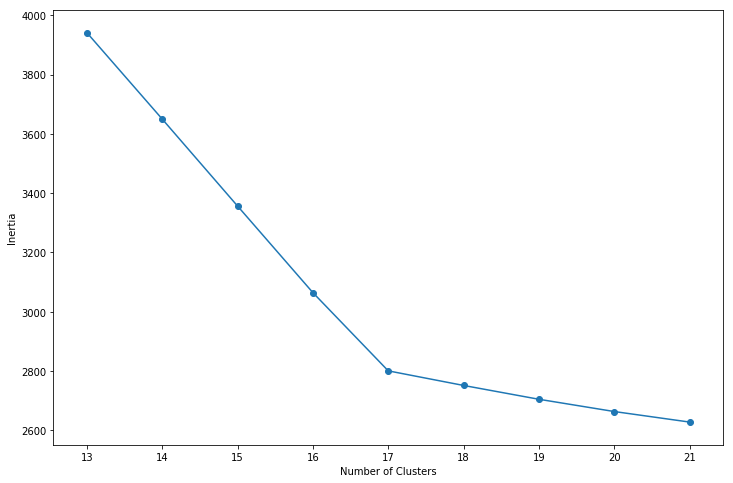

In [218]:
inertia = []
list_num_clusters = list(range(13,22))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=0, n_jobs=-1)
    km.fit(lda_W)
    inertia.append(km.inertia_)

plt.figure(figsize = (12,8))
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia');

In [ ]:
inertia = []
list_num_clusters = list(range(13,22))
for num_clusters in list_num_clusters:
    km = KMeans(n_clusters=num_clusters, random_state=0, n_jobs=-1)
    X_Norm = preprocessing.normalize(lda_W) # to normalise existing X
    km.fit(X_Norm)
    inertia.append(km.inertia_)

plt.figure(figsize = (12,8))
plt.plot(list_num_clusters,inertia)
plt.scatter(list_num_clusters,inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia - NORMALIZED');

# PLOTS

In [208]:
# write function that slices on label, and plots what you want.
def cluster_count_by_time(df, cluster_col, time_col, time_chunk, drop_biggest_cluster=False):
    df = df.loc[:, [cluster_col, time_col]]    
    plt.figure(figsize=(12,6), dpi=100)
    
#     plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
#     plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
#     plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
#     plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
    
    if not drop_biggest_cluster:
        num_clusters = range(len(df[cluster_col].unique()))
    else:
        num_clusters = range(1, len(df[cluster_col].unique()))
        
    for i in num_clusters:
        # slice DF to that label
        dfZ = df[df[cluster_col] == i]
        
        # group everything by year/time
        dfZ = dfZ.groupby([pd.Grouper(key=time_col, freq=time_chunk)]).count().reset_index()
        
        # plot dataframe
#         dfZ.plot(x=time_col, y=cluster_col, figsize=(12,8))
        plt.plot(dfZ[time_col], dfZ[cluster_col])
    plt.legend(labels=num_clusters)
    plt.show();

In [209]:
def cluster_norm_by_time(df, cluster_col, time_col, time_chunk, drop_biggest_cluster=False):
    df = df.loc[:, [cluster_col, time_col]]    
    plt.figure(figsize=(12,6), dpi=100)

    if not drop_biggest_cluster:
        num_clusters = range(len(df[cluster_col].unique()))
    else:
        num_clusters = range(1, len(df[cluster_col].unique()))
    
    for i in num_clusters:
        # create df with count of all labels by the time_chunk grouping
        df_master = df.groupby([pd.Grouper(key=time_col, freq=time_chunk)]).count()
        df_master.rename(columns={cluster_col:'count_of_all_labels'}, inplace=True)
        
        # create df with count of only INTERESTED cluster label by time_chunk grouping
        dfX = df[df[cluster_col] == i]
        
        # slice df to that ratio
        dfZ = dfX.groupby([pd.Grouper(key=time_col, freq=time_chunk)]).count()
        dfZ.rename(columns={time_chunk:'count_of_interest_label'}, inplace=True)
        
        # add column to master one (dfA)
        df_master['count_of_interest_only'] = dfZ
        
        #make ratio column
        df_master['ratio'] = df_master.count_of_interest_only / df_master.count_of_all_labels
        
        df_master = df_master.reset_index()
        # plot dataframe
#         dfZ.plot(x=time_col, y=cluster_col, figsize=(12,8))
        plt.plot(df_master[time_col], df_master['ratio'])
    plt.legend(labels=num_clusters)
    plt.show();

In [196]:
kmc = KMeansClusterer(17, distance=cosine_distance, repeats=25, avoid_empty_clusters=True)
assigned_clusters = kmc.cluster(lda_W, assign_clusters=True)

kmeans_df = pd.DataFrame(lda_W, copy=True)
kmeans_df['clusters'] = pd.Series(assigned_clusters)
kmeans_df['time'] = df.reset_index()['created_utc']
# kmeans_df.head()

In [199]:
for i in set(assigned_clusters):
    print('count of ',i,':::',assigned_clusters.count(i))

count of  0 ::: 2955
count of  1 ::: 2176
count of  2 ::: 2608
count of  3 ::: 2266
count of  4 ::: 8869
count of  5 ::: 2168
count of  6 ::: 2830
count of  7 ::: 2653
count of  8 ::: 2554
count of  9 ::: 2204
count of  10 ::: 2332
count of  11 ::: 1813
count of  12 ::: 2002
count of  13 ::: 2563
count of  14 ::: 2840
count of  15 ::: 461
count of  16 ::: 2363


In [203]:
kmeans_df.clusters.value_counts().sort_index()

0     2955
1     2176
2     2608
3     2266
4     8869
5     2168
6     2830
7     2653
8     2554
9     2204
10    2332
11    1813
12    2002
13    2563
14    2840
15     461
16    2363
Name: clusters, dtype: int64

In [207]:
df.iloc[kmeans_df[kmeans_df.clusters == 14].index]

,body,score,author,permalink,comment_id,created_loc,created_utc,post_title,post_score,post_id
6,i always forget lebron has basically played three extra seasons in the playoffs alone,1003,PRINCETONMOON,/r/nba/comments/65vxhi/if_lebron_scores_37_points_today_against_the/dgdk4za/,dgdk4za,2017-04-17 22:41:56,2017-04-17 14:41:56,"If LeBron scores 37 points today against the Pacers, he will pass Kobe in career playoff scoring",1276,65vxhi
10,lebron will also pass kobe in career playoff pointers if he makes,37,Heebs,/r/nba/comments/65vxhi/if_lebron_scores_37_points_today_against_the/dgdpo61/,dgdpo61,2017-04-18 00:30:29,2017-04-17 16:30:29,"If LeBron scores 37 points today against the Pacers, he will pass Kobe in career playoff scoring",1276,65vxhi
13,through his age season malone had minutes played thus far lebron has minutes if he gets to the finals that amount wi...,90,aydee123,/r/nba/comments/65q2sq/it_seems_like_people_rarely_bring_up_karl_malones/dgc9q3v/,dgc9q3v,2017-04-17 01:04:36,2017-04-16 17:04:36,It seems like people rarely bring up Karl Malone's longevity when talking about whether or not LeBron can continue d...,62,65q2sq
14,lebron has a similar physical profile to karl malone too and he could easily slide to the to elongate his career som...,29,NaN,/r/nba/comments/65q2sq/it_seems_like_people_rarely_bring_up_karl_malones/dgc9pcq/,dgc9pcq,2017-04-17 01:04:08,2017-04-16 17:04:08,It seems like people rarely bring up Karl Malone's longevity when talking about whether or not LeBron can continue d...,62,65q2sq
15,i'm calling it now lebron will never average less than ppg for the rest of his career barring a serious injury,41,thepinkmahindra,/r/nba/comments/65q2sq/it_seems_like_people_rarely_bring_up_karl_malones/dgc9knh/,dgc9knh,2017-04-17 01:01:14,2017-04-16 17:01:14,It seems like people rarely bring up Karl Malone's longevity when talking about whether or not LeBron can continue d...,62,65q2sq
26,lebron decides when he wants to play and when he wants to sit not lue,24,NaN,/r/nba/comments/65oz91/in_his_14th_season_lebron_james_led_the_league_in/dgc02o0/,dgc02o0,2017-04-16 21:02:02,2017-04-16 13:02:02,"In his 14th season LeBron James led the league in minutes per game at 37.8, Should Ty Lue be held accountable?",19,65oz91
41,lebron this ain't the regular season james,53,NaN,/r/nba/comments/65liwl/lebron_with_a_monster_jam/dgb74c6/,dgb74c6,2017-04-16 05:24:33,2017-04-15 21:24:33,LeBron with a monster jam,284,65liwl
43,i haven't seen bron get that hype all season,33,DylanMarshall,/r/nba/comments/65ldgh/richard_jefferson_hands_it_off_to_lebron_james/dgb5uhe/,dgb5uhe,2017-04-16 04:54:47,2017-04-15 20:54:47,Richard Jefferson hands it off to LeBron James for the slam in transition; the crowd and the Cavs go wild!,72,65ldgh
145,lebron throws off the weighed jerseys he's been playing in all season and proceeds to charge for the next series bef...,51,BelligerentCow,/r/nba/comments/65cfvq/lebron_on_why_he_likes_the_cavs_chances_ive_got/dg9gnuy/,dg9gnuy,2017-04-15 01:36:55,2017-04-14 17:36:55,"LeBron on why he likes the Cavs chances: ""I've got the answer. I'm not giving it to you, but I've got the answer why...",1405,65cfvq
149,i feel like i'm or years he'll dip to and average apg,492,bananaboatfloat22,/r/nba/comments/657uvw/bleacher_report_lebron_james_is_the_only_player/dg85qcb/,dg85qcb,2017-04-14 04:20:04,2017-04-13 20:20:04,[Bleacher Report] Lebron James is the only player in NBA History to average 25+ PPG For 13 Seasons straight.,1923,657uvw


In [205]:
kmeans_df[kmeans_df.clusters == 14].index

Int64Index([    5,     9,    12,    13,    14,    25,    40,    42,   142,
              146,
            ...
            45465, 45505, 45513, 45515, 45526, 45573, 45606, 45626, 45630,
            45639],
           dtype='int64', length=2840)

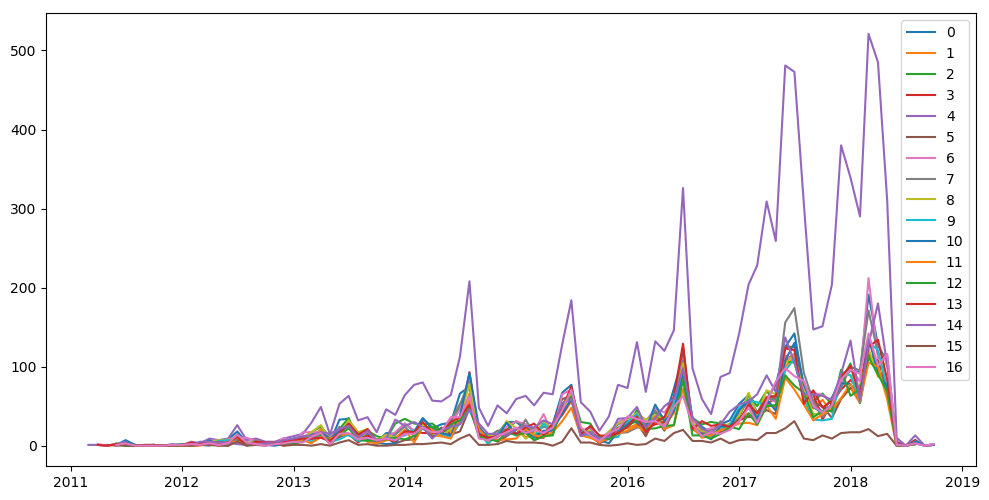

In [210]:
cluster_count_by_time(kmeans_df, cluster_col='clusters', time_col='time', time_chunk='M', drop_biggest_cluster=False)

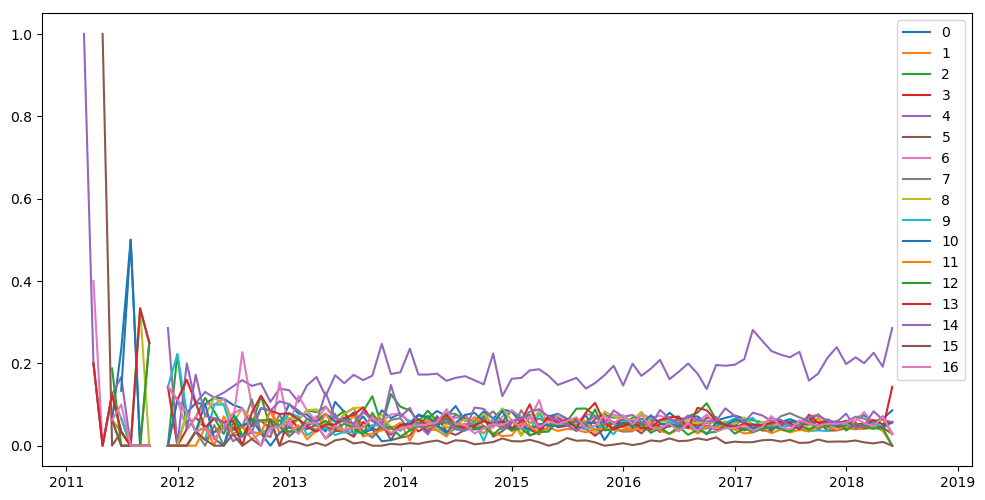

In [211]:
cluster_norm_by_time(kmeans_df, cluster_col='clusters', time_col='time', time_chunk='M', drop_biggest_cluster=False)

In [9]:
#ag = AgglomerativeClustering(n_clusters=2, affinity='cosine'

db = None
db = DBSCAN(eps=0.01, min_samples=25, metric='cosine', leaf_size=10, n_jobs=-1).fit(lda_model)

labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

unique, counts = np.unique(labels, return_counts=True)
print('counts')
print(np.asarray((unique, counts)).T)

Estimated number of clusters: 2
counts
[[   -1  6116]
 [    0 36081]
 [    1  3474]]


In [ ]:
DBdf.head()

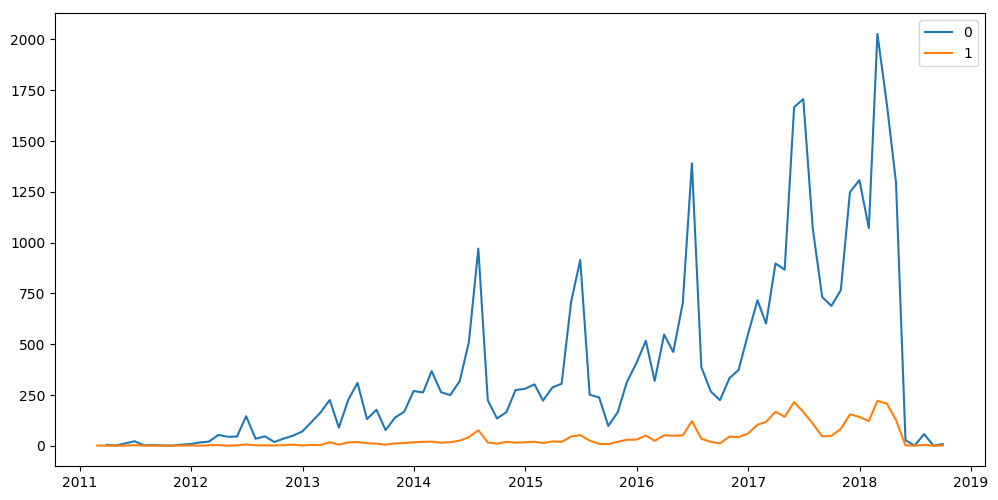

In [212]:
DBdf = pd.DataFrame(db.components_, index=db.core_sample_indices_, copy=True)
df2 = df.reset_index()
DBdf['cluster'] = pd.Series(db.labels_)
DBdf['created_utc'] = df2['created_utc']


cluster_count_by_time(DBdf, cluster_col='cluster', time_col='created_utc', time_chunk='M', drop_biggest_cluster=False)

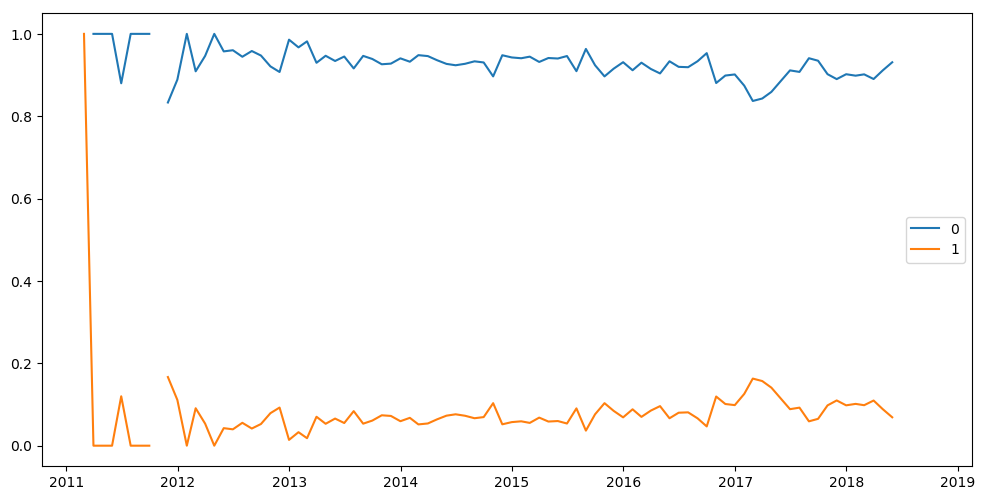

In [213]:
db_norm_df = pd.DataFrame(db.components_, index=db.core_sample_indices_, copy=True)
df2 = df.reset_index()
db_norm_df['cluster'] = pd.Series(db.labels_)
db_norm_df['created_utc'] = df2['created_utc']
db_norm_df = db_norm_df[['cluster', 'created_utc']]

cluster_norm_by_time(db_norm_df, cluster_col='cluster', time_col='created_utc', time_chunk='M', drop_biggest_cluster=False)

# Test NMF and Display topics better

In [139]:
def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("")
        print(f"Topic {topic_idx}")
        print("TOP WORDS:", " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort(W[:,topic_idx])[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
            print("DOC:", documents[doc_index][:100])

dataset = df.reset_index()
documents = dataset.body

no_features = 700

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, ngram_range=(1,3), stop_words=stops)
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CustomVectorizer(# strip_accents='ascii',
                               max_df=0.95,
                               min_df=2,
                               stop_words = stops,
                               max_features=no_features,
                               ngram_range=(1,3)
                              )
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

In [143]:
lda_model = LatentDirichletAllocation(n_components=16, max_iter=10, n_jobs=-1, learning_method='batch', learning_offset=50.,random_state=0).fit(tf)

In [142]:
# no_topics = 30

for no_topics in range(16, 19, 1):

    # Run NMF
#     nmf_model = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
#     nmf_W = nmf_model.transform(tfidf)
#     nmf_H = nmf_model.components_

    # Run LDA
    lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=10, n_jobs=-1, learning_method='batch', learning_offset=50.,random_state=0).fit(tf)
    lda_W = lda_model.transform(tf)
    lda_H = lda_model.components_

    no_top_words = 14
    no_top_documents = 8
#     print("")
#     print(f"{no_topics} TOPICS for TF-IDF and NMF RESULTS")
#     print("")
#     display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)
    print("")
    print(f"{no_topics} TOPICS for LDA and DTM RESULTS")
    print("")
    display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)


16 TOPICS for LDA and DTM RESULTS


Topic 0
TOP WORDS: wade shoot ever heat pass post alreadi bosh seen hell time point pleas thing
DOC: i'm out of words number is one of the greatest assists i've ever seen just the difficulty to pass it
DOC: isn't that mostly partially because lebron hasn't been shooting jump shots as often hard to shoot of
DOC: in a lot fewer games too if it already wasn't known he is the best shot blocking guard ever
DOC: lebrons passing ability and court vision is definitely his biggest strength on the court and he will
DOC: clearly a foul but oh my god that's one of the funniest and most ridiculous sells i've ever seen lma
DOC: that's wild i can't recall ever seeing the defender on a on break sticking with the cutter to deny t
DOC: this is not a good thing bosh did this for us with the raptors and dude just slowed down hes one of 
DOC: the least athletic block i've ever seen

Topic 1
TOP WORDS: give shot point mani anyon guard wonder definit second reason chanc n

In [ ]:
font = {'fontname':'Carlito',
             'size': 16}
    
    tickfont = {'fontname':'Carlito',
             'size': 16}
    
    titlefont = {'fontname':'Carlito',
             'size': 28}
    
#     fpr1, tpr1, _ = roc_curve(y_test, y_score_main)
# #     fpr2, tpr2, _ = roc_curve(y_test2, y_score_second)
#     plt.clf()
#     plt.figure(figsize = (8,8), dpi=300)
#     plt.xlim(xmin=0, xmax=1)
#     plt.ylim(ymin=0, ymax=1.001)
# #     plt.f
# #     plt.figlegend(
#     plt.figtext(.55, .35,'GB  AUC  =  .774',bbox=dict(facecolor='#FA3B66', alpha=0.8), **titlefont)
# #     plt.figtext(.55, .30,"GB  AUC  =  .806",bbox=dict(facecolor='#2274a5', alpha=0.5), **titlefont)

#     #Plot the baseline
#     plt.plot([0,1],[0,1], c='#ccced2', ls='--')
#     plt.plot(fpr1, tpr1, c='#FA3B66', linewidth=2.5, alpha = 0.8)
# #     plt.plot(fpr2, tpr2, c='#2274a5', linewidth=2)
#     plt.title('ROC Curve', **titlefont)
#     plt.xlabel('False Positive Rate', horizontalalignment='left', x=0, **hfont)
#     plt.ylabel('True Positive Rate', verticalalignment='top', y=1.045, rotation=0, labelpad = -59, **hfont)
#     plt.xticks(list(np.linspace(.1,1,10)), **tickfont)
#     plt.yticks(list(np.linspace(.1,1,10)), **tickfont)
#     plt.grid(b=True, which='major', axis='both', alpha=0.2)
#     plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
#     plt.gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_xticks()])
#     sns.despine(ax=plt.gca())

In [222]:
# # Save to do a hard-clustering algo like kmeans for later
# transformed_lda[0]
# transformed_lda[1]
# transformed_lda.argmax(axis=1)
# km = KMeans(n_clusters=5, init='k-means++', random_state=0, n_jobs=-1)
# topic_split = km.fit_transform(transformed_lda)
# topic_split[0]
# topic_split[2]
# topic_split.shape

In [33]:
cv = CountVectorizer(stop_words=stops, 
                     #analyzer=english_corpus,
                     analyzer=analyzer,
                     min_df = 3, max_df = .95, ngram_range=(1, 2),
                     strip_accents='unicode', 
                     encoding='utf-8',
                     # tokenizer=TreebankWordTokenizer().tokenize,
                     #max_features=100
                    )

In [33]:
dtm_tf = cv.fit_transform(df_small_train.body)
dtm_tf.shape

(14000, 5298)

# LDA

In [34]:
pd.DataFrame(dtm_tf.toarray(), columns=cv.get_feature_names()).shape

lda_tf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tf.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, cv)

KeyboardInterrupt: 

# TF-IDF

In [71]:
cv2 = CountVectorizer(#stop_words=stops, 
                     analyzer=english_corpus, 
                     min_df = 2, max_df = .95, #ngram_range=(1, 2),
                     strip_accents='unicode', encoding='utf-8')

tfidf_vectorizer = TfidfVectorizer(**cv2.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(df_small_train.body)

lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=0)
lda_tfidf.fit(dtm_tfidf)

pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1547: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  UserWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.051493 -0.005656       1        1  17.891667
7     -0.068342  0.014101       2        1  13.069484
5     -0.035743 -0.013699       3        1   9.888963
4     -0.070377 -0.058975       4        1   9.431428
1     -0.082874 -0.050363       5        1   9.166373
6      0.089967  0.041093       6        1   8.382241
3     -0.002557  0.129411       7        1   8.372704
2      0.082768  0.092074       8        1   8.316884
9     -0.001495 -0.011377       9        1   8.013487
8      0.140146 -0.136609      10        1   7.466769, topic_info=     Category       Freq      Term      Total  loglift  logprob
term                                                           
1510  Default  34.000000      nice  34.000000  30.0000  30.0000
491   Default  33.000000   confirm  33.000000  29.0000  29.0000
593   Default  46.000000      damn  46.000000  28.0000  28.0000
696   Default  22.000000     doubl  22.000000  27.0000  27.0000
1261  Default  20.000000      king  20.000000  26.0000  26.0000
1458  Default  18.000000      miss  18.000000  25.0000  25.0000
1390  Default  65.000000       man  65.000000  24.0000  24.0000
2403  Default  16.000000     tripl  16.000000  23.0000  23.0000
1382  Default  24.000000     magic  24.000000  22.0000  22.0000
1897  Default  42.000000     right  42.000000  21.0000  21.0000
1552  Default  20.000000        oh  20.000000  20.0000  20.0000
1010  Default  26.000000       god  26.000000  19.0000  19.0000
2331  Default  14.000000       tho  14.000000  18.0000  18.0000
1367  Default  65.000000      love  65.000000  17.0000  17.0000
1446  Default  15.000000   million  15.000000  16.0000  16.0000
1985  Default  54.000000    season  54.000000  15.0000  15.0000
1781  Default  18.000000  question  18.000000  14.0000  14.0000
1842  Default  15.000000   regular  15.000000  13.0000  13.0000
1045  Default  43.000000       guy  43.000000  12.0000  12.0000
2382  Default  15.000000     trade  15.000000  11.0000  11.0000
445   Default  25.000000     coach  25.000000  10.0000  10.0000
1614  Default  27.000000      pass  27.000000   9.0000   9.0000
1830  Default  14.000000    record  14.000000   8.0000   8.0000
1875  Default  16.000000   respect  16.000000   7.0000   7.0000
336   Default  28.000000      call  28.000000   6.0000   6.0000
1415  Default  24.000000      mean  24.000000   5.0000   5.0000
103   Default  23.000000     anyon  23.000000   4.0000   4.0000
1278  Default  17.000000      lanc  17.000000   3.0000   3.0000
2358  Default  15.000000     today  15.000000   2.0000   2.0000
28    Default  11.000000        ad  11.000000   1.0000   1.0000
...       ...        ...       ...        ...      ...      ...
136   Topic10   1.836326  assassin   2.601165   2.2465  -6.4022
1401  Topic10   1.772000    martin   2.536830   2.2359  -6.4379
1462  Topic10   2.239007        mo   3.221734   2.2308  -6.2040
1515  Topic10   6.359971    nobodi   9.640802   2.1787  -5.1600
1875  Topic10  10.100956   respect  16.101310   2.1284  -4.6974
2550  Topic10   5.587835      west   8.584732   2.1653  -5.2894
736   Topic10   3.532103     earth   5.281132   2.1925  -5.7481
1252  Topic10   3.969750       kat   6.067462   2.1705  -5.6313
1278  Topic10   9.606736      lanc  17.530202   1.9932  -4.7475
103   Topic10  11.903119     anyon  23.768682   1.9031  -4.5332
2250  Topic10   6.523186     super  12.347907   1.9566  -5.1346
2522  Topic10   3.774530      wall   6.325863   2.0783  -5.6817
212   Topic10   5.995098    behind  12.764355   1.8390  -5.2191
1312  Topic10   4.452740     legit   8.572849   1.9396  -5.5165
2258  Topic10   4.457640   surpris   8.655915   1.9311  -5.5154
1266  Topic10  10.888165      know  47.357496   1.1247  -4.6223
740   Topic10   4.665654    easili   9.482974   1.8854  -5.4698
1110  Topic10   4.447925      hold   9.409466   1.8454  -5.5176
765   Topic10   5.365001       els  17.279312